<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [62]:
import re
import string

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import spacy
import squarify

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from collections import Counter
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_lg")
tokenizer = Tokenizer(nlp.vocab)

In [63]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

## 1) *Clean:* Job Listings from indeed.com that contain the title "Data Scientist" 

You have `job_listings.csv` in the data folder for this module. The text data in the description column is still messy - full of html tags. Use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column. You will need to read thru the documentation to accomplish this task. 

`Tip:` You will need to install the `bs4` library inside your conda environment. 

In [23]:
from bs4 import BeautifulSoup
import requests

In [24]:
def unicodetoascii(text):

    TEXT = (text.
    		replace('\\xe2\\x80\\x99', "'").
            replace('\\xc3\\xa9', 'e').
            replace('\\xe2\\x80\\x90', '-').
            replace('\\xe2\\x80\\x91', '-').
            replace('\\xe2\\x80\\x92', '-').
            replace('\\xe2\\x80\\x93', '-').
            replace('\\xe2\\x80\\x94', '-').
            replace('\\xe2\\x80\\x94', '-').
            replace('\\xe2\\x80\\x98', "'").
            replace('\\xe2\\x80\\x9b', "'").
            replace('\\xe2\\x80\\x9c', '"').
            replace('\\xe2\\x80\\x9c', '"').
            replace('\\xe2\\x80\\x9d', '"').
            replace('\\xe2\\x80\\x9e', '"').
            replace('\\xe2\\x80\\x9f', '"').
            replace('\\xe2\\x80\\xa6', '...').
            replace('\\xe2\\x80\\xb2', "'").
            replace('\\xe2\\x80\\xb3', "'").
            replace('\\xe2\\x80\\xb4', "'").
            replace('\\xe2\\x80\\xb5', "'").
            replace('\\xe2\\x80\\xb6', "'").
            replace('\\xe2\\x80\\xb7', "'").
            replace('\\xe2\\x81\\xba', "+").
            replace('\\xe2\\x81\\xbb', "-").
            replace('\\xe2\\x81\\xbc', "=").
            replace('\\xe2\\x81\\xbd', "(").
            replace('\\xe2\\x81\\xbe', ")")

                 )
    return TEXT

In [25]:
df = pd.read_csv('data/job_listings.csv', index_col=0)
df['description'] = df['description'].apply(unicodetoascii)
df.head(10)

,description,title
0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,b'<ul><li>Location: USA - multiple locations</...,Data Scientist
5,b'<div>Create various Business Intelligence An...,Data Scientist
6,b'<div><p>As Spotify Premium swells to over 96...,Associate Data Scientist – Premium Analytics
7,"b""Everytown for Gun Safety, the nation's large...",Data Scientist
8,"b""<ul><li>MS in a quantitative discipline such...",Sr. Data Scientist
9,b'<div><p>Slack is hiring experienced data sci...,"Data Scientist, Lifecyle"


In [26]:
df['description'] = df['description'].str[2:]
df.head()

,description,title
0,<div><div>Job Requirements:</div><ul><li><p>\n...,Data scientist
1,<div>Job Description<br/>\n<br/>\n<p>As a Data...,Data Scientist I
2,<div><p>As a Data Scientist you will be workin...,Data Scientist - Entry Level
3,"<div class=""jobsearch-JobMetadataHeader icl-u-...",Data Scientist
4,<ul><li>Location: USA - multiple locations</li...,Data Scientist


In [27]:
df = df.applymap(lambda text: BeautifulSoup(text, 'html.parser').get_text())
df.head(10)

,description,title
0,Job Requirements:\nConceptual understanding in...,Data scientist
1,"Job Description\n\nAs a Data Scientist 1, you ...",Data Scientist I
2,As a Data Scientist you will be working on con...,Data Scientist - Entry Level
3,"$4,969 - $6,756 a monthContractUnder the gener...",Data Scientist
4,Location: USA - multiple locations\n2+ years o...,Data Scientist
5,Create various Business Intelligence Analytica...,Data Scientist
6,As Spotify Premium swells to over 96M subscrib...,Associate Data Scientist – Premium Analytics
7,"Everytown for Gun Safety, the nation's largest...",Data Scientist
8,MS in a quantitative discipline such as Statis...,Sr. Data Scientist
9,Slack is hiring experienced data scientists to...,"Data Scientist, Lifecyle"


## 2) Use Spacy to tokenize the listings 

In [66]:
# Tokenizer Pipe

tokens = []

""" Make them tokens """
for doc in tokenizer.pipe(df['description'], batch_size=500):
    doc_tokens = [token.text for token in doc]
    for token in doc: 
        if token.text.lower() not in nlp.Defaults.stop_words:
            doc_tokens.append(token.text.lower())
    tokens.append(doc_tokens)

df['tokens'] = tokens
df.head()

,description,title,tokens
0,Job Requirements:\nConceptual understanding in...,Data scientist,"[Job, Requirements:\nConceptual, understanding..."
1,"Job Description\n\nAs a Data Scientist 1, you ...",Data Scientist I,"[Job, Description\n\nAs, a, Data, Scientist, 1..."
2,As a Data Scientist you will be working on con...,Data Scientist - Entry Level,"[As, a, Data, Scientist, you, will, be, workin..."
3,"$4,969 - $6,756 a monthContractUnder the gener...",Data Scientist,"[$4,969, -, $6,756, a, monthContractUnder, the..."
4,Location: USA - multiple locations\n2+ years o...,Data Scientist,"[Location:, USA, -, multiple, locations\n2+, y..."


## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [67]:
data = [item for item in df['description']]
data[0]

'Job Requirements:\\nConceptual understanding in Machine Learning models like Nai\\xc2\\xa8ve Bayes, K-Means, SVM, Apriori, Linear/ Logistic Regression, Neural, Random Forests, Decision Trees, K-NN along with hands-on experience in at least 2 of them\\nIntermediate to expert level coding skills in Python/R. (Ability to write functions, clean and efficient data manipulation are mandatory for this role)\\nExposure to packages like NumPy, SciPy, Pandas, Matplotlib etc in Python or GGPlot2, dplyr, tidyR in R\\nAbility to communicate Model findings to both Technical and Non-Technical stake holders\\nHands on experience in SQL/Hive or similar programming language\\nMust show past work via GitHub, Kaggle or any other published article\\nMaster\'s degree in Statistics/Mathematics/Computer Science or any other quant specific field.\\nApply Now"'

In [68]:
from sklearn.feature_extraction.text import CountVectorizer

# text
data = [item for item in df['description']]

# create the transformer
vect = CountVectorizer()

# build vocab
vect.fit(data)

# transform text
# dtm = document term matrix
dtm = vect.transform(data)

In [69]:
print(vect.get_feature_names()[:25])

['00', '000', '02115', '03', '0356', '04', '062', '06366', '08', '10', '100', '1000', '1001', '1008', '100k', '100x', '105', '1079302', '1082692', '10b', '10ms', '10x', '11', '110k', '112']


In [70]:
print(dtm)

  (0, 225)	1
  (0, 498)	1
  (0, 569)	2
  (0, 608)	2
  (0, 661)	1
  (0, 675)	1
  (0, 697)	1
  (0, 755)	1
  (0, 915)	1
  (0, 1072)	1
  (0, 1474)	1
  (0, 1530)	1
  (0, 1614)	1
  (0, 1691)	1
  (0, 2074)	1
  (0, 2135)	1
  (0, 2171)	1
  (0, 2486)	1
  (0, 2620)	1
  (0, 2852)	1
  (0, 2964)	2
  (0, 2981)	1
  (0, 3137)	1
  (0, 3164)	1
  (0, 3253)	1
  :	:
  (425, 9572)	2
  (425, 9596)	1
  (425, 9605)	1
  (425, 9641)	1
  (425, 9662)	1
  (425, 9698)	1
  (425, 9719)	1
  (425, 9767)	1
  (425, 9791)	2
  (425, 9828)	1
  (425, 9834)	1
  (425, 9836)	1
  (425, 9842)	2
  (425, 9855)	3
  (425, 9857)	1
  (425, 9871)	10
  (425, 9873)	2
  (425, 9874)	1
  (425, 9884)	6
  (425, 9890)	1
  (425, 9893)	1
  (425, 9896)	1
  (425, 9966)	2
  (425, 9977)	3
  (425, 9979)	1


In [71]:
dtm.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 2, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0]], dtype=int64)

In [72]:
dtm.shape

(426, 9994)

In [73]:
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
dtm.head()

,00,000,02115,03,0356,04,062,06366,08,10,...,zenreach,zero,zeus,zf,zheng,zillow,zones,zoom,zuckerberg,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4) Visualize the most common word counts

C:\Users\Rob\.virtualenvs\DS-Unit-4-Sprint-1-NLP-5VV_i8j-\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


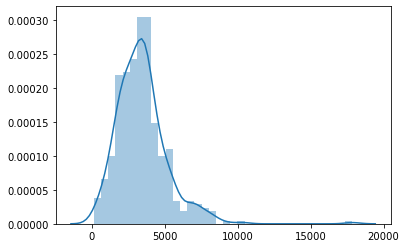

In [77]:
doc_len = [len(doc) for doc in data]
sns.distplot(doc_len);

In [75]:
wc = count(df['tokens'])
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
130,and,425,11477,1.0,0.035613,0.035613,0.997653
109,data,420,6737,2.0,0.020905,0.056519,0.985915
25,to,422,6736,3.0,0.020902,0.077421,0.990610
392,the,414,4931,4.0,0.015301,0.092722,0.971831
48,of,420,4532,5.0,0.014063,0.106784,0.985915


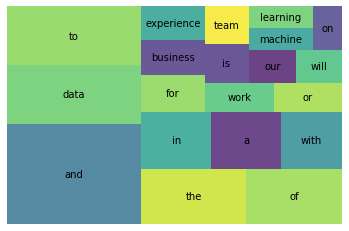

In [76]:
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [81]:
# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words=nlp.Defaults.stop_words)

# Similiar to fit_predict
dtm = tfidf.fit_transform(data)

# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
dtm.head()

,00,000,02115,03,0356,04,062,06366,08,10,...,zenreach,zero,zeus,zf,zheng,zillow,zones,zoom,zuckerberg,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.104422,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [88]:
# Fit on DTM
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [92]:
nn.kneighbors([dtm.iloc[100]])

(array([[0.        , 0.        , 1.22380181, 1.2354787 , 1.2354787 ]]),
 array([[ 47, 100, 201, 184, 147]], dtype=int64))

In [87]:
ideal_job_desc = ["""
AwesomeJobs Inc is seeking an innovative Machine Learning Engineer (MLE) to join our team and help create the next generation of machine learning solutions. 
The developer will work as part of a cross-functional team consisting of data scientists and engineers to tackle challenging machine learning problems and 
transform research into robust, deployment-ready solutions.
"""]

In [95]:
new = tfidf.transform(ideal_job_desc)
nn.kneighbors(new.todense())

(array([[1.2473147 , 1.2473147 , 1.27519351, 1.284964  , 1.29416852]]),
 array([[192, 252, 261, 399, 151]], dtype=int64))

In [96]:
data[252]

"InternshipPosition Description\\nThe candidate will work along side data scientists / engineers in the team to work on challenging machine learning problems and explore how state-of-the-art machine learning / deep learning approaches can be applied to the E-commerce domain.\\nMinimum Qualifications\\nMachine learning, algorithm, data structure.\\nAdditional Preferred Qualifications\\nPlease add text\\nCompany Summary\\nThe Walmart eCommerce team is rapidly innovating to evolve and define the future state of shopping. As the world's largest retailer, we are on a mission to help people save money and live better. With the help of some of the brightest minds in technology, merchandising, marketing, supply chain, talent and more, we are reimagining the intersection of digital and physical shopping to help achieve that mission.\\nPosition Summary\\nThe candidate will work along side data scientists / engineers in the team to work on challenging machine learning problems and explore how sta

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 